## **Reverse auto_diff and computational grpahs to implement neural networks**

### **Building the "Node" class: The basic unit of our network**

#### 1) STEP-1:
- Only stores a single data value and + and * operations are overloaded
#### 2) STEP-2: (adding the children and _op attributes)
- Now we want our Node object to store the Node obejcts that are used to compute the given Node.
- Thus we add the **children** attribute to our Node object, it is initialised with an empty tuple.
- The children attribute should pass an empty tuple only when a leaf node is created, for an intermidiate node all the Node objects involved in the computation of the new Node must be passed to the children tuple.
- **self._op** is used for labeling while visualising the graph.
- _Observe that the overloaded operation functions are created in such a way that operations act as connectors between multiple Node objects_.
#### 3) STEP-3: (A function to visualise the graph created using graphviz)
- recursively traverse all relations from a given root node to create a visualisation of the interconnections
- While creating a node in graphviz the name parameter is used to uniquely identify a node. We use the unique pyhton id for this parameter.
- initially the attribute self._op stored the operation's value as a string, but string being immutable python assigns same 'id' to strings with the same value. that is: a='abc' and b='abc' will have the same python id and this leads to wrong graph representations.
- later self._op was made to store operation values as lists of strings. Lists being mutable have different pyhton ids even for same valued lists.
#### 4) STEP-4: (The sigmoid, Relu operations and _grad attribute)
- Most neural networks use the sigmoid and relu as activation functions.
- Rev_autodiff/backpropogation works on the chain rule.
- While training neural networks before the gradient descent/weight correction step is performed we need the gradient of the cost function which is nothing but a vector containing the derivatives of the cost function with respect to each weight of the neural network.
- Here we are looking at a much general implementation for a start, the **_grad** attribute of each Node will store the partial derivative of the root Node of the graph w.r.t itself for the currently set values of the graph.
#### 5) STEP-5: (The backward pass and accumulating gradients)
- It can be observed that a given Node object stores all info what operation connects its children, this tells us everything about the relation between the children and given Node object.
- Now while computing derivatives w.r.t a root Node i.e. the top of the chain, we'll need the info about the derivatives of the immidiate parent w.r.t the current node inorder to compute d(root)/d(curr).
- acc to chain rule d(root)/d(curr)=SUM_OVER_i(d(root)/d(parent_i)*d(parent_i)/d(curr))
- The idea is to somehow save for every Node the tasks to be done during a backward pass, these tasks are:
    1) compute the derivative of the root node w.r.t its children.
    2) call the backward function for the children (if they arent leaf nodes).
- This can be done by creating a _backward() function during the creation of a new Node object (any Node object will be created inside the overloaded operation fucntions only). This _backward() function's scope can be saved in a function object which can be assigned to an attribute of the new Node object.
#### 6) STEP-6: (The "dotpr" function and making the Node class vectorised)
- The Node class is useless(for neural network implementation) untill it can deal with arrays (both in the forward and backward pass).
- For this we do the following changes:
    1) initialise self.data with numpy arrays instead of floats.
    2) self._grad will now store a numpy array of the same shape as self.data.
    3) self._grad[i] will store the derivative of the root Node w.r.t self.data[i].
    4) introduce a new operation "dot". This operation will create a new node with data as the dot product of its input arrays.
    5) write an appropriate _backward() function for "dot" operation and modify _backward() functions of add and multiply operations.

In [230]:
import graphviz
import numpy as np

In [231]:
class Node:
    def __init__(self, data, label='', children=(), _op=[]):
        self.data=np.array(data, dtype=float)
        self.label=label
        self.children=children
        self._op=_op    # basically each node itself stores the relation which relates it to its children in _op
        self._grad=np.zeros(shape=self.data.shape, dtype=float)   # stores the derivative of the root node w.r.t the current node
        # each element of _grad represents a seperate parameter
        # Thus each element of _grad will store the derivative of root node w.r.t that parameter
        self._backward= lambda: None
    
    # A magic function which shows customised msg to display the object
    def __repr__(self):
        return f"Node: data={np.array2string(self.data, precision=4, floatmode='fixed')}, label='{self.label}', op='{self._op}'"
    
    def __add__(self, other):
        new_node=Node(self.data+other.data, children=(self, other), _op=["+"])
        
        # Defining the backward function for the new_node
        # will do 2 things:
        # 1) compute the gradients of new_node's children w.r.t the root using the chain rule
        # 2) call the backward function for new_node's children if they are not leaf nodes
        def _backward():
            new_node.children[0]._grad+=new_node._grad
            new_node.children[1]._grad+=new_node._grad
            
            for child in new_node.children:
                if(child._op):  #child is not a leaf node
                    child._backward()
        
        # Any Node which is formed by the addition operation, will know through _backward() what to do in reverse pass.
        # here a function object of the _backward() function is passed to the new_node object's _backward attribute
        # we need to take speacial care while considering the scope of the _backward() fucntion object.
        new_node._backward=_backward
            
        return new_node
    
    # this operation multiplies corresponding elements of self.data and other.data and returns a Node obejct with data as 
    # array of same size.
    def __mul__(self, other):
        new_node=Node(self.data*other.data, children=(self, other), _op=['*'])
        
        def _backward():
            new_node.children[0]._grad+=(new_node._grad)*(new_node.children[1].data)
            new_node.children[1]._grad+=(new_node._grad)*(new_node.children[0].data)
            
            for child in new_node.children:
                if(child._op):  #child is not a leaf node
                    child._backward()
                    
        new_node._backward=_backward
        return new_node
    
    # creates a Node with data as the dot product of two vectors
    def dotpr(self, other):
        new_node=Node(np.sum((self.data)*(other.data)), children=(self, other), _op=['dot'])
        
        def _backward():
            new_node.children[0]._grad+=(new_node._grad)*(new_node.children[1].data)
            new_node.children[1]._grad+=(new_node._grad)*(new_node.children[0].data)
            new_node.children[0]._backward()
            new_node.children[1]._backward()
            
        new_node._backward=_backward
        return new_node
    
    def sig(self):
        new_node=Node(1/(1+pow(np.e, -self.data)), children=(self, ),_op=['sig'])
        
        def _backward():
            new_node.children[0]._grad+=(new_node.data)*(1-new_node.data)*new_node._grad
            
            if(new_node.children[0]._op):  #child is not a leaf node
                new_node.children[0]._backward()
                    
        new_node._backward=_backward
        return new_node
    
    
    # The loss function
    def BinCrossEntropy(self, y):   # y is the target value for a given datapoint
        new_node=Node(-y*np.log(self.data)-(1-y)*np.log(1-self.data),children=(self,), _op=["BCE"])

        def _backward():
            new_node.children[0]._grad+=(((1-y)/(1-new_node.children[0].data))-(y/new_node.children[0].data))*new_node._grad

            if(new_node.children[0]._op):  #child is not a leaf node
                new_node.children[0]._backward()

        new_node._backward=_backward
        return new_node
        
    # fucntion to convert a list of Nodes with monovalued data to a single Node with array data
    # used to connect 2 consecutive layers of a neural network
    @staticmethod
    def buffer(Nodes:list):
        new_node=Node([node.data for node in Nodes], children=tuple(Nodes), _op=['buf'])
        
        def _backward():
            i=0
            for child in new_node.children:
                child._grad+=new_node._grad[i]
                i+=1
            
            for child in new_node.children:
                if(child._op):
                    child._backward()
                    
        new_node._backward=_backward
        return new_node
        
    # Initialising the backward pass to compute gradients
    # The Node in single quotes while specifying type of root is used for fwd declaration in python
    @staticmethod
    def backward(root:'Node'):
        root._grad=np.ones(shape= root.data.shape, dtype=float)
        root._backward()

### **Function to visualise the graph using graphviz**
NOTE: if not explicitly mentioned, wherever captialised 'N' is used in 'Node' it refers to the Node class object

1) Computational graphs are directed grpahs.
2) The basic idea is to call all Node objects involved in the graph recursively, and create graphviz nodes 
   corresponding to each of them.
3) A Node object has 3 peices of information: 
   - self.data and self.label: will be used in representing data nodes.
   - self.children: all children of the current Node object will be recursively called.
   - self._op: operations tell us how a given node is related to its children, will have seperate nodes in the visualisation.
4) The unique id assigned by python to each object implicitly is used to name nodes of the graph 
5) For a connection like: (curr1), (curr2) -> (parent._op) -> (parent)
   - the parent._op and parent connection was formed during parent's recursion call.
   - the curr and parent._op connection is formed during the current recursion call.
   - if curr._op is non empty then a connection between curr._op and curr is imperitive.

In [232]:
def draw_graph(root: Node)-> graphviz.graphs.Digraph:
    #initialising the graph
    graph=graphviz.Digraph(format='svg', name="Comp_graph", graph_attr={"rankdir":"LR"}, comment="Computational graph")
    
    # creating the parent node in the visualisation
    uidr=str(id(root))  # unique id of the root Node object
    graph.node(uidr, label=f"{root.label} | data: {np.array2string(root.data, precision=4, floatmode='fixed')} | grad: {np.array2string(root._grad, precision=4, floatmode='fixed')}", shape="record")
    
    if root._op:    #checking if root._op is empty or not, if not empty then create node for operation
        uidr_op=str(id(root._op))
        graph.node(uidr_op, label=f"{root._op}")
        graph.edge(uidr_op, uidr)   # uidr_op (tail) -> uidr (head)
    else:
        return graph
    
    """ there exists a possibilty that 2 Nodes share a single child, in such a scenario we dont want to create
    two nodes in the visualisation for a single Node object, thus we'll have to maintain a "SET" of Node objects
    which have been aldready included in the representation."""
    
    """
    There also exists a possibility that a Node calls its children again and again due to calls from multiple parents
    to the Node. We need to avoid multiple calls from a given parent while visualisaing the graph. (multiple recursive
    calls from the same parent to the same child lead to unecessary arrows in the graph visualisation).
    """
    check=set((uidr))
    edges={(uidr, uidr_op)}
    
    def rec(curr: Node, parent: Node):
        uid=str(id(curr))
        if uid not in check:   #checking if current node aldready has a node in visualisation or not
            # creating curr Node object in the visualisation
            graph.node(uid, label=f"{curr.label} | data: {np.array2string(curr.data, precision=4, floatmode='fixed')} | grad: {np.array2string(curr._grad, precision=4, floatmode='fixed')}", shape="record")
            check.add(uid)
        if tuple((uid, str(id(parent._op)))) in edges:
            return
        graph.edge(uid, str(id(parent._op)))    # add an edge between parent's operation and curr node
        edges.add((uid, str(id(parent))))
            
        # adding an edge between current node and its operation
        if curr._op:
            uid_op=str(id(curr._op))
            graph.node(uid_op, label=f"{curr._op}")
            if tuple((uid_op, uid)) in edges:
                return
            graph.edge(uid_op, uid)
            edges.add((uid_op,uid))
        else:   # if the current Node object has no operation i.e. it is a leaf node
            return
        
        for child1 in curr.children:
            rec(child1, curr)
        
    for child in root.children:
        rec(child, root)    # recursive call to immidiate children of the root node.
        
    return graph

### **Some examples to test code**

Node: data=[0.9526], label='f', op='['sig']'
(Node: data=[3.0000], label='e', op='['*']',)


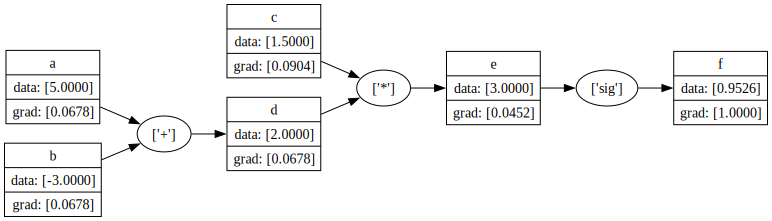

In [233]:
a=Node([5], 'a')
b=Node([-3.0], 'b')
c=Node([1.5], 'c')
d=a+b; d.label='d'
e=c*d; e.label='e'
f=e.sig(); f.label='f'
print(f)
print(f.children)
Node.backward(f)
draw_graph(f)

Node: data=0.1330, label='f', op='['sig']'
(Node: data=-1.8750, label='e', op='['*']',)


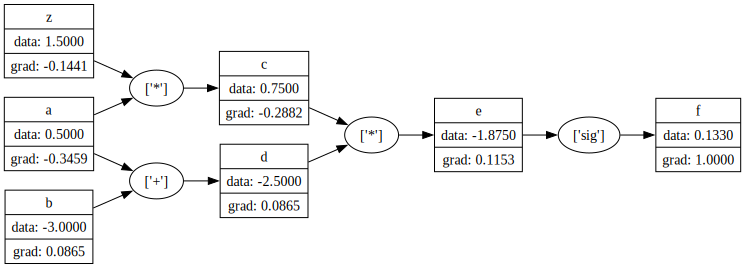

In [234]:
a=Node(0.5, 'a')
z=Node(1.5, 'z')
b=Node(-3.0, 'b')
c=a*z; c.label='c'
d=a+b; d.label='d'
e=c*d; e.label='e'
f=e.sig(); f.label='f'
print(f)
print(f.children)
Node.backward(f)
draw_graph(f)

### **Implementing a single neuron using the vectorised Node class**

Node: data=1.7839, label='BCE', op='['BCE']'
(Node: data=0.8320, label='sig', op='['sig']',)


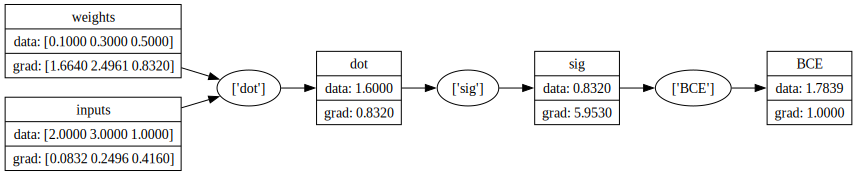

In [235]:
w=Node([.1,.3,.5], label='weights')
x=Node([2,3,1], label='inputs')
wdotx=w.dotpr(x); wdotx.label='dot'
out1=wdotx.sig(); out1.label='sig'
out=out1.BinCrossEntropy(0); out.label='BCE'
print(out)
print(out.children)
Node.backward(out)
draw_graph(out)

### **Building a neural network using Node class**

- A neural network is made by stringing together multiple layers.
- We will need to define 3 classes: 1) The Neuron class, 2) The layer class, 3) Neural_Network class
- A single neuron must consist of 2 Node class objects: 1) Dot Node and 2) Activation fucntion Node

#### 1) STEP-1: (initialising routine for Neuron, layer and netowork classes)
- The **Network** class when initialised takes a list as input, the first element denotes the number of input parameters expected, the elements that follow are **Layer** class objects. A Layer can be initialised in 2 ways:
    1) through the Network class (implicit initialisation): The create_neurons() function is used.
    2) directly during runtime (explicit initialisation): __init__() of Layers class handles creation of neurons.

- The following tasks are done when a **Network** object is created:
    1) assign appropriate values to num_inp attribute of all layers.
    2) Create the Neuron_list for each layer using create_neurons() function, this list holds all Neuron objects for that layer.
    3) Call the self.__ call __(random_input) function for a fwd pass across the network which initialises all input Nodes of the network. Save the final output node as the self.root attribute of the network.
    4) The __ call __ method of the **Network** class call the __ call __ method for all its layers. __ call __ method for the **Layer** class sets the input attribute of itself to the input **Node** object recieved(Input recieved to a layer is shared by all its neurons). The layer's __ call __ metod returns a buffer **Node** containing outputs from all neurons in that layer.
    5) This buffer **Node** is then passed to the next layer. The final buffer **Node** is made the root of the network.

- A **Neuron** can be initialised only through layers. It involves random initialisation of a self.weights **Node** object.
- Take good care while defining labels as they would be displayed in the graphviz visualisation.

#### 2) STEP-2: (Building the forward pass through the network and visualising the network)
- An input array when provided to a layer must return an array of outputs with size = num of neurons in the layer.
- What must be kept in mind is that all the underlying cross-layer **Node** objects must be connected to facilitate the draw_graph() and backward() functions properly. 
    1) __ call __ for **Network** class:
    - recieves input as a np.array. Convert this array into a Node class object
    - Iterate over the self.layers attribute of the network obj.
    - For each layer in self.layers __ call __ for the **Layer** object is called and the output of the previous layer(this output is a buffer **Node** object) is passed to it.
    - Return the final output.
    - Store final output **Node** object in the "root" attribute of the network. this will be used in drawing the network using draw_graph function.
    2) __ call __ for **Layer** class:
    - Recieves input a **Node** class object. A single input Node object is shared by the entire Layer. Thus it is logical to make a self.inputs attribute for the **Layer** class.
    - Iterate over the neuron_list and pass the input Node to compute the dot product and the activation function.
    - A python list of **Node** objects is created, each object's 'data' attribute contains a single value.
    - Define a static method buffer() for the **Node** class which converts a list of **Node** objects with single-valued data to a single **Node** object of with data as array. This step is crucial to establish connection between 2 layers.
    - Return the new **Node** object formed. This acts as input to the next layer.
    3) __ call __ for Neuron class:
    - use dotpr() function to get dot product of weights and input Node.
    - pass the resulting Node to the sig() function.
    - creates 2 Node objects: wdoti and sigz which act as attributes of the neuron.
    - return the sig() Node object formed.
- wrap the draw_graph() function for the Network class.
#### 3) STEP-3: (Building the backward pass and the BinaryCrossEntropy loss)
- The backward pass through the network will compute gradients for all Node objects in the network.
- A backward() method of the Network class wraps a call to the backward function of the Node class on the self.root 
attribute of the Network object.
- Add a loss function method to the Node class. Hard code the BinaryCrossEntropy fucntion and its derivative.

#### 4) STEP-4: (The train() function and the score() function)
- Implements stocastic gradient descent on the given dataset.
- Iterate over the input array with each iteration involving the following steps:
    1) Forward pass: calculate the loss for a given training example
    2) Backward pass: compute the gradients of loss w.r.t weights
    3) Weight update: 
        - Fwd pass through the network again but this time to slightly update wieghts.
        - Weight update will start from the Neurons of the lowest layer.
        - once the weights of a Neuron are updated, we will have to reset the _grad value of the Nodes to zero arrays to make them ready for the next iteration
- Repeat the iteration on the input array for the number of epochs given.

In [236]:
class Neuron:
    def __init__(self, num_par, activation, label=''):
        self.label=label
        self.activation = activation
        self.num_par=num_par
        # rand_obj=np.random.RandomState(seed=123) was used earlier to keep getting same initial weights and troubleshoot
        self.weights=Node(np.random.rand(num_par+1), label=f"W: {self.label}")    # the last weight will be the bias
        # Inputs for an entire layer are the outputs of the previous layer
        # thus there is no specific need to create spereate Node objects for each neuron for the same input array 
        #self.inputs=Node(np.ones(num_par+1), label="")
        
    def __call__(self, input:Node):
        wdoti=self.weights.dotpr(input); wdoti.label=f"D: {self.label}"
        sigz=wdoti.sig(); sigz.label=f"S: {self.label}"
        self.wdoti=wdoti
        self.sigz=sigz
        return self.sigz
        
class Layer:
    def __init__(self, units:int, activation='',num_inp=0, label=''):
        self.units=units
        self.activation=activation
        self.num_inp=num_inp
        self.label=label
        self.neuron_list=[]
        
        # this will keep track of the input Node to a layer(used in weight update step to reset gradients)
        # this input node could be given by the user in the __call__ fucntion or can be buffer node storing previous
        # layer's outputs aswell
        
        # every layer will have to take some input inorder to compute further
        self.inputs=Node(np.zeros((self.num_inp+1)))
        if(num_inp!=0):     
            """
            IF A LAYER IS EXPLICITLY DECLARED i.e not through the network class.
            """
            self.neuron_list=[Neuron(self.num_inp,self.activation,label=f"{self.label}, N{i}") for i in range(units)]
    
    def create_neurons(self):
        """
        INCASE A LAYER IS IMPLICITLY DECLARED i.e. through the network class.
        """
        self.neuron_list=[Neuron(self.num_inp,self.activation,label=f"{self.label}, N{i}") for i in range(self.units)]
    
    #initiates a fwd pass through the layer
    def __call__(self, input:Node):
        self.inputs=input
        # This buffer Node connects the outputs of Neurons of a layer to the next layer.
        # These outputs serve as inputs to the next layer.
        buffer_node=Node.buffer([neuron(self.inputs) for neuron in self.neuron_list]); buffer_node.label=f"I: L{int(self.label[1])+1}"
        return buffer_node
        
    def get_weights(self):
        weights=np.array([neuron.weights.data for neuron in self.neuron_list])
        return weights
    
class Network:
    def __init__(self, layers:list):
        self.layers=layers
        self.inp_par=layers[0][0]   # the shape of the input is defined by the first element of the list passed
        
        # 1) INITIALISING NUM_INP FOR ALL LAYERS OF THE NETWORK
        layers[1].num_inp=self.inp_par   # the number of weights (excl. bias) each neuron of this layer would have
        layers[1].create_neurons()
        for i in range(2,len(layers)):
            layers[i].num_inp=layers[i-1].units            
            # for eg: num of units in the first layer=3; num of inputs for the next layer=3(excl. bias)
            # num of weights for each neuron in the second layer=3(excl. bias)
            
            # 2) CREATE NEURON OBJECTS FOR EACH LAYER
            layers[i].create_neurons()
            
        # 3) CONNECTING THE LAYERS: to connect the layers we'll have to fwd pass through the network once
        # initialising the root, the root Node has _op as buffer
        # The below line calls the __call__ fucntion of the newtwork being initialised.
        # this initialisation is important because connects all the layers of the network
        self.root=self(np.random.rand(self.inp_par))
            
        
    def __call__(self, input):
        input=np.array(input).reshape((self.inp_par))
        #adding 1 at the end of the input array
        input=np.r_[input, 1]    
        #creating input Node object, this object belongs to the entire layer
        output=Node(input,label=f"I: L1")
        for layer in self.layers[1:]:
            output=layer(output)
            """ 
            Consider an example, suppose the current layer has 3 output neurons, thus layer(temp) would return a Node
            object with data as a np.array of size (3,). But now Neurons of the next layer would need to have an input
            of size (4,). Thus, we'll have to add the bias term to 'output' Node.
            """
            output.data=np.r_[output.data, 1]
            output._grad=np.r_[output._grad, 0]
        output.data=np.array([output.data[0]], dtype=float)
        output._grad=np.array([output._grad[0]], dtype=float)
        self.root=output    # saving the root Node object of the Network
        return output
    
    def backward(self):
        Node.backward(self.root)
    
    def train(self, X, Y, epoch, alpha):
        l=[]
        X=np.array(X, dtype=float)
        Y=np.array(Y, dtype=float)
        for _ in range(epoch):
            for i in range(X.shape[0]):
                x=X[i]
                y=Y[i]
                # 1) fwd pass and calculating
                # loss for the datapoint assuming activation to be sigmoid
                y_p=self(x)
                self.root=y_p.BinCrossEntropy(y); self.root.label='Loss'
                print(self.root)
                
                # 2) backward pass
                self.backward()
                
                # 3) Weight update step: data=data-(alpha*_grad) for every neuron
                # only the weights of the neurons will be updated
                # once the wieghts are updated the _grad attribute will be reset to 0 for the next iteration
                # NOTE: that _grad attribute will have to be reset for all nodes not just the weights
                for layer in self.layers[1:]:
                    for neuron in layer.neuron_list:
                        neuron.weights.data = neuron.weights.data-(alpha*neuron.weights._grad)                   
                        neuron.weights._grad=np.zeros(neuron.weights.data.shape)
                        neuron.wdoti._grad=np.zeros(neuron.wdoti.data.shape)
                        neuron.sigz._grad=np.zeros(neuron.sigz.data.shape)
                    layer.inputs._grad=np.zeros(layer.inputs._grad.shape)   # Input Node objects of layers (_op= buffer)
                self.root.children[0]._grad=np.array([0], dtype=float)   # This is a Node object with _op = buffer
                self.root._grad=np.array([0], dtype=float)   # This is a Node object with _op = BCE
                
                # 'l' contains graphviz.Digraph objects, each is a graph made after one weight update step
                # l.append(self.draw())
        self.root=self.root.children[0]
        return l
    
    def score(self, X,Y):
        i=0
        count=0
        for x in X:
            c=float(self(x).data[0])>.5
            if Y[i]==c:
                count+=1
            i+=1
        return count/Y.shape[0]             
    
    def get_weights(self):
        for layer in self.layers[1:]:
            print(f"{layer.label}\nWeights: \n{layer.get_weights()}")
            
    def draw(self):
        return draw_graph(self.root)

### **Testing the entire framework**

In [237]:
model=Network([(2,), 
               Layer(units=2, activation='sigmoid', label='L1'),
               Layer(units=3, activation='sigmoid', label='L2'),
               Layer(units=1, activation='sigmoid', label='L3')])

# number of inputs = number of weights for each neuron in the first layer
# layers will be created in a sequential order from left to right
# the network is inititalised with random parameters and inputs

#### Visualising initial weights:
##### All weights and inputs of the Network obejct are initialised randomly. NOTE: that there is no Node for the LOSS initially. LOSS Node is created in the train fucntion.

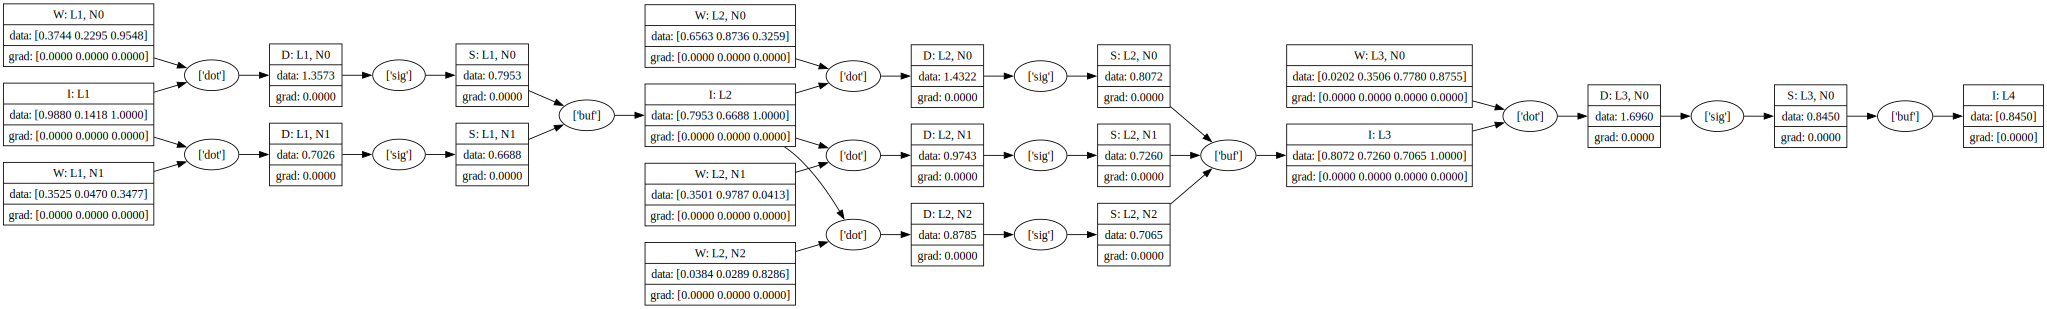

In [238]:
model.draw()

#### Checking reverse pass through the network:
##### Notice the that the gradients have also been populated now.

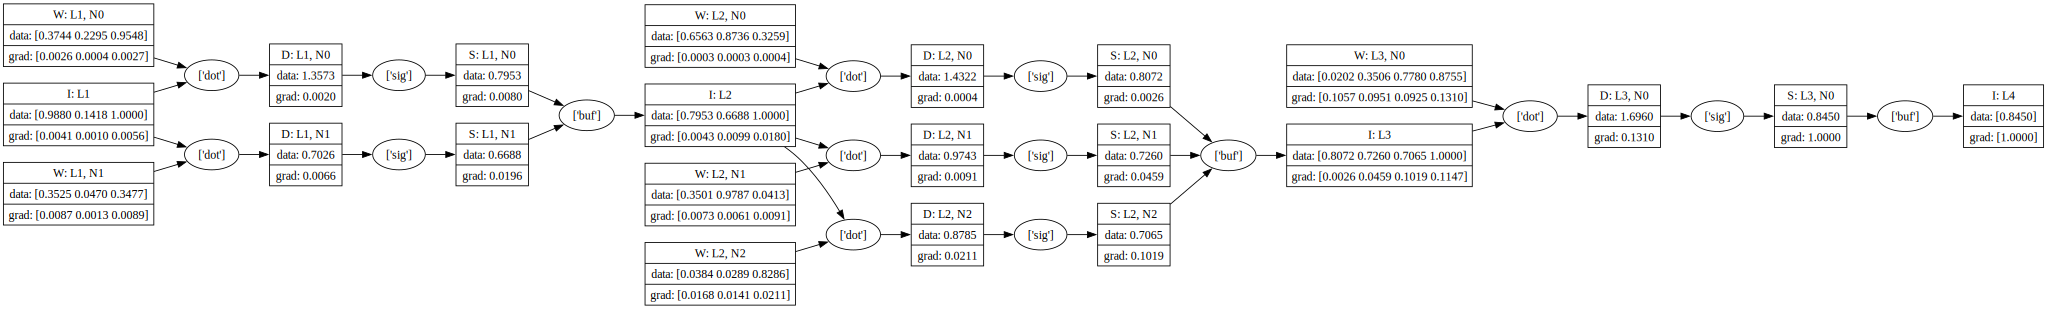

In [239]:
model.backward()
model.draw()

#### Manual gradient update step: (No LOSS function used)
##### Notice how only the weight nodes have been updated, all other Nodes(input, dot, sig, buf) remain unaffected. Also see that all the gradients have been reset to zero, this makes our network ready for the next datapoint input.

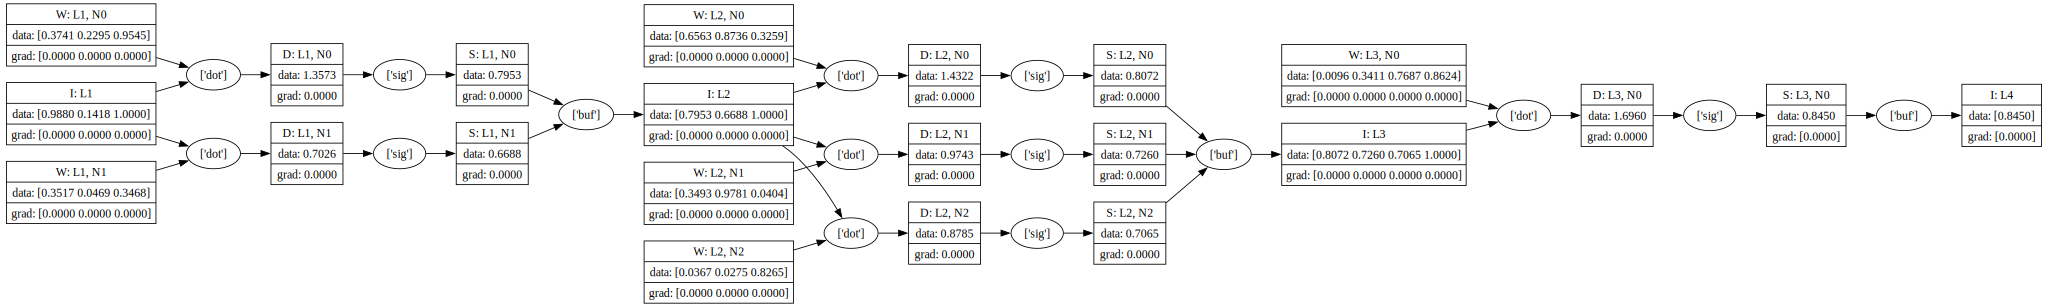

In [240]:
# manual gradient update
alpha=.1
for layer in model.layers[1:]:
    for neuron in layer.neuron_list:
        neuron.weights.data = neuron.weights.data-(alpha*neuron.weights._grad)        
        neuron.weights._grad=np.zeros(neuron.weights.data.shape)
        neuron.wdoti._grad=np.zeros(neuron.wdoti.data.shape)
        neuron.sigz._grad=np.zeros(neuron.sigz.data.shape)
    layer.inputs._grad=np.zeros(layer.inputs._grad.shape)   # Input Node objects of layers (_op= buffer)
model.root.children[0]._grad=np.array([0], dtype=float)   # This is a Node object with _op = buffer
model.root._grad=np.array([0], dtype=float)   # This is a Node object with _op = BCE
model.draw()

All the above tasks are performed for a given datapoint in the train() function.

#### Testing the train() function:
##### We first test using a small trivial dataset, and check if the loss decreases over iterations. Clearly, the loss is gradually decreasing indicating that the train fucntion works as expected.

In [241]:
X=np.array([[1,2],[3,4],[4,5]])
Y=np.array([0,1,0])
X,Y

(array([[1, 2],
        [3, 4],
        [4, 5]]),
 array([0, 1, 0]))

In [242]:
l=model.train(X,Y, 10, .1)      # the decreasing Loss shows that all passes work fine.

Node: data=[1.8369], label='Loss', op='['BCE']'
Node: data=[0.2128], label='Loss', op='['BCE']'
Node: data=[1.6984], label='Loss', op='['BCE']'
Node: data=[1.5057], label='Loss', op='['BCE']'
Node: data=[0.3016], label='Loss', op='['BCE']'
Node: data=[1.4010], label='Loss', op='['BCE']'
Node: data=[1.2455], label='Loss', op='['BCE']'
Node: data=[0.4002], label='Loss', op='['BCE']'
Node: data=[1.1713], label='Loss', op='['BCE']'
Node: data=[1.0467], label='Loss', op='['BCE']'
Node: data=[0.5011], label='Loss', op='['BCE']'
Node: data=[0.9977], label='Loss', op='['BCE']'
Node: data=[0.8975], label='Loss', op='['BCE']'
Node: data=[0.5978], label='Loss', op='['BCE']'
Node: data=[0.8678], label='Loss', op='['BCE']'
Node: data=[0.7862], label='Loss', op='['BCE']'
Node: data=[0.6859], label='Loss', op='['BCE']'
Node: data=[0.7707], label='Loss', op='['BCE']'
Node: data=[0.7030], label='Loss', op='['BCE']'
Node: data=[0.7636], label='Loss', op='['BCE']'
Node: data=[0.6977], label='Loss', op='[

In [243]:
model.get_weights()

L1
Weights: 
[[0.38778726 0.26039873 0.97182662]
 [0.38359653 0.11372532 0.38168626]]
L2
Weights: 
[[ 0.67911679  0.89245835  0.35205981]
 [ 0.33503983  0.96592496  0.02489616]
 [-0.04263841 -0.0393612   0.73814024]]
L3
Weights: 
[[-0.60506454 -0.20869781  0.26011394  0.12015256]]


In [245]:
model.score(X,Y)

0.6666666666666666

##### Since python implementation is slow using the above set of classes we can only train Neural networks for small datasets.